## Trackball Analysis
*Nhat Le, May 2018*

This is a file for analysis of the left/right trackball behavior and imaging data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd


%matplotlib inline

In [2]:
# Load the data from the mat files
rawc_data = scipy.io.loadmat('raw_c.mat', squeeze_me=True)['raw_c']
rawi_data = scipy.io.loadmat('raw_i.mat', squeeze_me=True)['raw_i']
mean_velc_data = scipy.io.loadmat('mean_vel_c.mat', squeeze_me=True)['mean_vel_c']
mean_veli_data = scipy.io.loadmat('mean_vel_i.mat', squeeze_me=True)['mean_vel_i']
mvmt_startc = scipy.io.loadmat('mvmt_start_c.mat', squeeze_me=True)['mvmt_start_c']
mvmt_starti = scipy.io.loadmat('mvmt_start_i.mat', squeeze_me=True)['mvmt_start_i']
rtc = scipy.io.loadmat('rt_c.mat', squeeze_me=True)['rt_c']
rti = scipy.io.loadmat('rt_i.mat', squeeze_me=True)['rt_i']
trial_orderc = scipy.io.loadmat('trial_order_c.mat', squeeze_me=True)['trial_order_c']
trial_orderi = scipy.io.loadmat('trial_order_i.mat', squeeze_me=True)['trial_order_i']


ref_table = scipy.io.loadmat('ref_table.mat')['ref_table']
ref_frame = pd.DataFrame(ref_table, columns=['unit', 'session', 'id_sess', 'SC', 'modulated', 'side'])

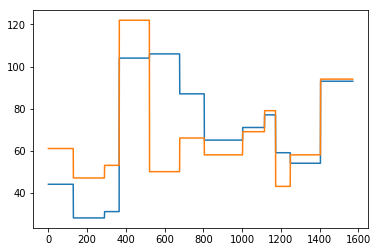

In [3]:
def get_ntrials(data):
    '''Given a raw data struct, return an array of the number 
    of trials that each cell was recorded'''
    ntrials = []
    for i in range(len(data)):
        ntrials.append(len(data[i]))
    return ntrials

ntrialsC = get_ntrials(mean_velc_data)
ntrialsI = get_ntrials(mean_veli_data)

# Maximum number of trials for each cell
ntrials_max = np.max(ntrialsC + ntrialsI)

# Number of cells
ncells = len(ntrialsC)

plt.plot(ntrialsC)
plt.plot(ntrialsI)

We pad all cells with nans to have the same number of trials.

In [ ]:
def make_tidy_frame(raw_struct, contra, varname, ncells):
    '''Inputs: raw_struct, the raw data array
    contra: 1 if contra, 0 if ipsi
    ncells: number of cells
    ntrials_max: max number of trials
    Returns a tidy data frame with columns: cells, trials, varname and contra'''
    ntrials = get_ntrials(raw_struct)
    ntrials_max = max(ntrials)
    ncells = len(ntrials)
    
    cell_arr = np.empty((ncells, ntrials_max + 1))
    cell_arr[:] = np.nan

    for i in range(ncells):
        cell_arr[i, 1:ntrialsC[i] + 1] = raw_struct[i]
        cell_arr[i, 0] = i
    
    
    

In [4]:
# Contra trials
mean_velC_arr = np.empty((ncells, ntrials_max + 1))
mean_velC_arr[:] = np.nan

for i in range(ncells):
    mean_velC_arr[i, 1:ntrialsC[i] + 1] = mean_velc_data[i]
    mean_velC_arr[i, 0] = i
    
# Ipsi trials
mean_velI_arr = np.empty((ncells, ntrials_max + 1))
mean_velI_arr[:] = np.nan

for i in range(ncells):
    mean_velI_arr[i, 1:ntrialsI[i] + 1] = mean_veli_data[i]
    mean_velI_arr[i, 0] = i

# Note that the first element of each array is the cell number

In [24]:
# Contra trials
mean_velC_fr = pd.DataFrame(mean_velC_arr)
mean_velC_fr = pd.melt(mean_velC_fr, id_vars=[0], var_name='trial', value_name='mean_v')
mean_velC_fr.columns = ['cellID', 'trial', 'mean_v']
mean_velC_fr = mean_velC_fr.dropna()
mean_velC_fr['contra'] = 1

# Ipsi trials
mean_velI_fr = pd.DataFrame(mean_velI_arr)
mean_velI_fr = pd.melt(mean_velI_fr, id_vars=[0], var_name='trial', value_name='mean_v')
mean_velI_fr.columns = ['cellID', 'trial', 'mean_v']
mean_velI_fr = mean_velI_fr.dropna()
mean_velI_fr['contra'] = 0

#TODO: modify so that we don't have to do this subtraction
mean_velC_fr.trial = mean_velC_fr.trial - 1
mean_velI_fr.trial = mean_velI_fr.trial - 1

### Tidy data
Make a tidy data frame that contains all the information

In [25]:
mean_velC_fr

,cellID,trial,mean_v,contra
0,0.0,0,145.039121,1
1,1.0,0,145.039121,1
2,2.0,0,145.039121,1
3,3.0,0,145.039121,1
4,4.0,0,145.039121,1
5,5.0,0,145.039121,1
6,6.0,0,145.039121,1
7,7.0,0,145.039121,1
8,8.0,0,145.039121,1
9,9.0,0,145.039121,1


In [8]:


data_dict = {'hi': [1, 2, 3], 'ho': [4, 5, 6]}
pd.DataFrame(data_dict)

,hi,ho
0,1,4
1,2,5
2,3,6


In [9]:
np.min(trial_orderc[0])

5

In [10]:
np.min(trial_orderi[0])

4

(array([11.,  5.,  3.,  6., 22., 11.,  3.,  2.,  1.,  1.]),
 array([0.01 , 0.045, 0.08 , 0.115, 0.15 , 0.185, 0.22 , 0.255, 0.29 ,
        0.325, 0.36 ]),
 <a list of 10 Patch objects>)

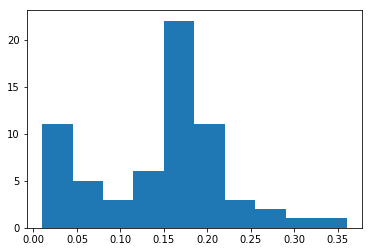

In [11]:
plt.hist(mvmt_startc[900])
# The two bumps are suggestive of two different modes of operation - 
# TODO: take a look at 
# the neural signatures of those two modes

In [12]:
mean_velc_data[0].shape
mean_veli_data[0].shape


(61,)

In [13]:
ref_frame

,unit,session,id_sess,SC,modulated,side
0,1.0,1.0,1.0,0.0,0.0,NaN
1,2.0,1.0,2.0,0.0,0.0,NaN
2,3.0,1.0,3.0,0.0,0.0,NaN
3,4.0,1.0,4.0,0.0,0.0,NaN
4,5.0,1.0,5.0,0.0,0.0,NaN
5,6.0,1.0,6.0,1.0,0.0,NaN
6,7.0,1.0,7.0,1.0,0.0,NaN
7,8.0,1.0,8.0,1.0,1.0,0.0
8,9.0,1.0,9.0,0.0,0.0,NaN
9,10.0,1.0,10.0,1.0,1.0,0.0


In [14]:
x = np.arange(10)
x[2:5]

array([2, 3, 4])

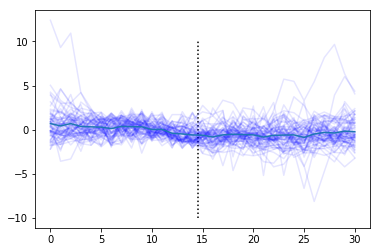

In [15]:
# Find z-score
cell_data = rawc_data[900]
#plt.plot(cell_data);

baseline_start = 5
baseline_end = 15

baseline_activity = cell_data[baseline_start:baseline_end]

# Find mean and std baseline
baseline_mean = np.mean(baseline_activity, axis=0)
baseline_sd = np.std(baseline_activity, axis=0)

# Normalize
cell_data_normed = (cell_data - baseline_mean) / baseline_sd
mean_cell_data = np.mean(cell_data_normed, axis=1)


plt.plot(cell_data_normed, 'b', alpha=0.1);
plt.plot(mean_cell_data)
plt.vlines(14.5, -10, 10, linestyles='dotted')

In [16]:
cell_data.shape

(31, 65)

In [17]:
a = (cell_data - baseline_mean) / baseline_sd


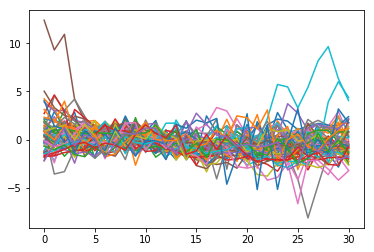

In [18]:
plt.plot(a);

In [19]:
cell_data

array([[ 60.63004772,  31.15639662,  33.75498214, ..., -24.99513412,
         -9.20415631, -19.65128894],
       [ 55.12491923,  12.39390677,  -4.4036865 , ..., -35.39638836,
         -1.79097286,  12.31359427],
       [ 39.8350084 ,  40.58043099,   8.5640232 , ..., -20.82949263,
          8.18453902,  43.65010556],
       ...,
       [ 35.04464095, -20.81690899,  -9.60473139, ..., -44.00765107,
        -35.44836868,  15.94370935],
       [ 31.75398039, -19.02863916, -61.89045061, ...,  -5.14733674,
        -37.86344064, -18.00597133],
       [ 15.41610785,  40.27872739, -57.90252458, ..., -45.02738188,
         16.54068546, -10.64137542]])

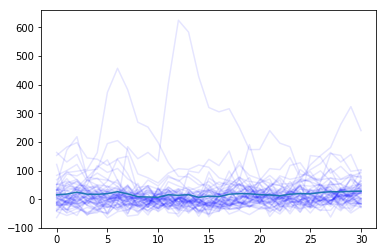

In [20]:
cell_num = 1400
mean_cell = np.mean(rawc_data[cell_num], axis=1)

plt.plot(rawc_data[cell_num], 'b', alpha=0.1);
plt.plot(mean_cell)

In [21]:
means = np.zeros((1572, 31))

for i in range(1572):
    celldata = rawc_data[i]
    means[i,:] = np.mean(celldata, axis=1)

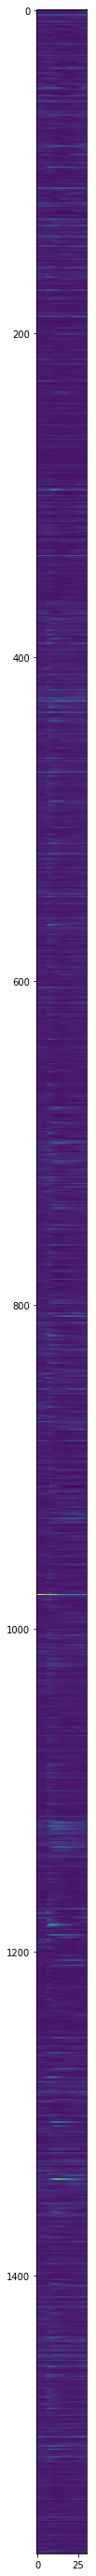

In [22]:
plt.figure(figsize=(15,50))
plt.imshow(means)

In [23]:
# Modulated cells are all SC
ref_pd.groupby('modulated')['SC'].mean()

NameError: name 'ref_pd' is not defined

In [ ]:
ref_pd[ref_pd.session == 1]

In [ ]:
# Group by SC
ref_pd.groupby('SC')['modulated'].mean()

In [ ]:
ref_pd.groupby('SC')['side'].mean()

## Correlation between cell activity and mean velocity

In [ ]:
# TODO: look at correlation between velocity and cell activity
ncell = 20
cell_data = rawc_data[ncell]
mean_cell_activity = np.mean(cell_data, axis=0)
plt.scatter(mean_cell_activity, mean_velc_data[ncell])